In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import log_loss, f1_score, classification_report, accuracy_score, roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
import pickle

In [2]:
test = pd.read_parquet('test.parquet', engine='pyarrow')
train = pd.read_parquet('train.parquet', engine='pyarrow')
valid = pd.read_parquet('valid.parquet', engine='pyarrow')
test.head()

,is_canceled,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,booking_changes,adr,required_car_parking_spaces,...,assigned_room_type_I,assigned_room_type_K,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,season_Spring,season_Summer,season_Winter
0,0,-0.001882,-0.801038,0.245144,-0.29955,-0.10083,-0.176313,-0.413398,0.081070,-0.296177,...,-0.062134,-0.045663,-0.118188,-0.036752,-0.077495,-2.121972,2.486513,1.630607,-0.700974,-0.46928
1,0,-0.980673,-0.305838,-1.752678,-0.29955,-0.10083,-0.176313,4.925791,-1.515416,-0.296177,...,-0.062134,-0.045663,-0.118188,-0.036752,-0.077495,0.471260,-0.402170,1.630607,-0.700974,-0.46928
2,0,-0.001882,-0.801038,0.245144,-0.29955,-0.10083,-0.176313,-0.413398,0.041158,-0.296177,...,-0.062134,-0.045663,-0.118188,-0.036752,-0.077495,0.471260,-0.402170,-0.613269,1.426586,-0.46928
3,0,-0.980673,0.189362,0.245144,-0.29955,-0.10083,-0.176313,-0.413398,-0.757085,-0.296177,...,-0.062134,-0.045663,-0.118188,-0.036752,-0.077495,-2.121972,2.486513,-0.613269,-0.700974,-0.46928
4,1,-0.001882,-0.801038,0.245144,-0.29955,-0.10083,-0.176313,-0.413398,-0.876822,-0.296177,...,-0.062134,-0.045663,8.461124,-0.036752,-0.077495,-2.121972,2.486513,-0.613269,1.426586,-0.46928


In [3]:
X_train = train.drop('is_canceled', axis=1)
y_train = train['is_canceled']
X_test = test.drop('is_canceled', axis=1)
y_test = test['is_canceled']
X_valid = valid.drop('is_canceled', axis=1)
y_valid = valid['is_canceled']

In [ ]:
# Randomized hyperparameter search
rf = RandomForestClassifier(random_state=42)
param_distributions = {
    'n_estimators': randint(100, 500),       
    'max_depth': [None] + list(range(5, 50, 5)),
    'min_samples_split': randint(2, 11),       
    'min_samples_leaf': randint(1, 4),          
    'max_features': [None, 'sqrt', 'log2', 0.8] 
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=100,                   # Number of parameter combinations to try
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
random_search.fit(X_train, y_train)

# Feature selection using best model (rest remains the same)
best_rf = random_search.best_estimator_
selector = SelectFromModel(best_rf, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Re-fit best model on selected features
best_rf_selected = RandomForestClassifier(**random_search.best_params_, random_state=42)
best_rf_selected.fit(X_train_selected, y_train)

# Evaluation
print("\n=== Best Hyperparameters ===")
print(random_search.best_params_)

y_pred = best_rf_selected.predict(X_test_selected)
y_pred_proba = best_rf_selected.predict_proba(X_test_selected)[:,1]
print(f"Weighted F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

selected_features = X_train.columns[selector.get_support()]
print(f"\nSelected {len(selected_features)} features:")
print(selected_features.tolist())


Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\weili\anaconda3\envs\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\weili\anaconda3\envs\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(



=== Best Hyperparameters ===
{'max_depth': 25, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 212}
Weighted F1 Score: 0.8605
Accuracy Score: 0.8621

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6896
           1       0.81      0.75      0.78      3275

    accuracy                           0.86     10171
   macro avg       0.85      0.83      0.84     10171
weighted avg       0.86      0.86      0.86     10171


Selected 19 features:
['stays_in_weekend_nights', 'stays_in_week_nights', 'booking_changes', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'log_lead_time', 'room_type_same', 'length_of_stay', 'total_guests', 'cancel_history_ratio', 'cancellation_lead_interaction', 'country_encoded', 'hotel_Resort Hotel', 'market_segment_Offline TA/TO', 'market_segment_Online TA', 'deposit_type_Non Refund', 'customer_type_Transient', 'customer_type_Transi

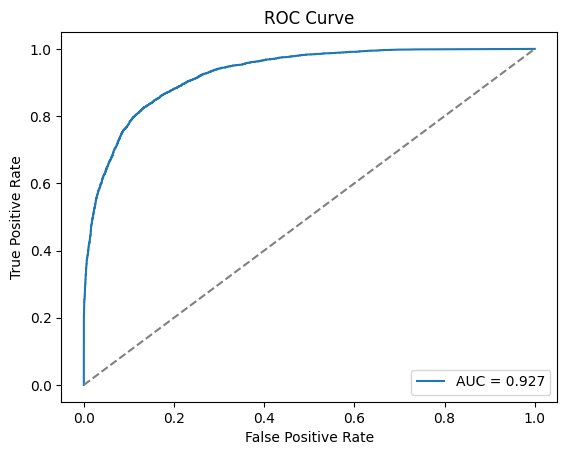

In [4]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


## Final Model

Log Loss: 0.3262
F1 Score: 0.7771


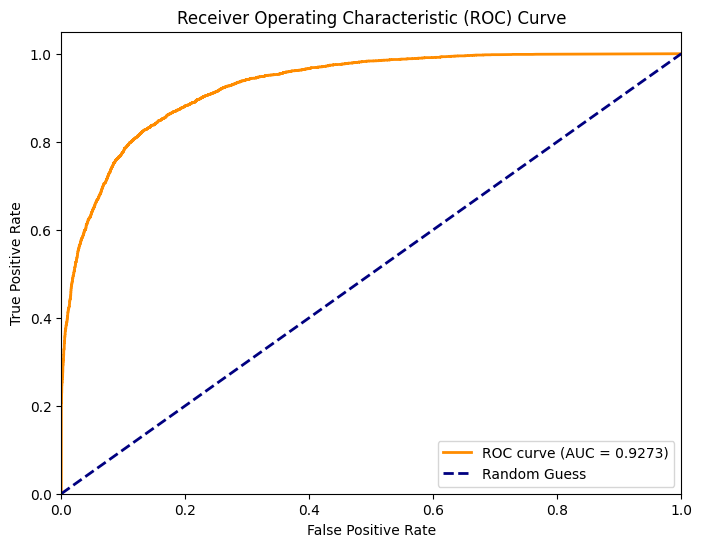

AUC: 0.9273


In [5]:
# Given hyperparameters
params = {
    'max_depth': 25,
    'max_features': 0.8,
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 212
}

# List of selected features
selected_features = [
    'stays_in_weekend_nights', 'stays_in_week_nights', 'booking_changes', 'adr',
    'required_car_parking_spaces', 'total_of_special_requests', 'log_lead_time',
    'room_type_same', 'length_of_stay', 'total_guests', 'cancel_history_ratio',
    'cancellation_lead_interaction', 'country_encoded', 'hotel_Resort Hotel',
    'market_segment_Offline TA/TO', 'market_segment_Online TA',
    'deposit_type_Non Refund', 'customer_type_Transient', 'customer_type_Transient-Party'
]

# Ensure only selected features are used
X_train_rf = X_train[selected_features]
X_test_rf = X_test[selected_features]

# Step 1: Train the Random Forest Classifier
rf = RandomForestClassifier(**params, random_state=42)
rf.fit(X_train_rf, y_train)

# Step 2: Predict Probabilities and Classes
y_proba = rf.predict_proba(X_test_rf)[:, 1]  # Probability of class 1
y_pred = (y_proba >= 0.5).astype(int)  # Binary predictions using threshold 0.5

# Step 3: Calculate Log Loss
logloss = log_loss(y_test, y_proba)
print(f"Log Loss: {logloss:.4f}")

# Step 4: Calculate F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# Step 5: Calculate ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc:.4f}")

In [6]:
# save the iris classification model as a pickle file
model_pkl_file = "randomforest.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(rf, file)


In [8]:
# load model from pickle file
with open(model_pkl_file, 'rb') as file:  
    model = pickle.load(file)

# evaluate model 
y_predict = model.predict(X_test_rf)

# check results
print(classification_report(y_test, y_predict)) 

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6896
           1       0.81      0.75      0.78      3275

    accuracy                           0.86     10171
   macro avg       0.85      0.83      0.84     10171
weighted avg       0.86      0.86      0.86     10171

